## Model performance evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This is the same functzion we created when looking at Euclidean and Manhatten distances
def euclidean_distance(data, student, student_to_compare): 
    distance = (
        pd.DataFrame({
            'student_1':data.loc[student,:],
            'student_2':data.loc[student_to_compare,:]
        })
        # applying the formula
        .assign(dist_abs = lambda x: (x.student_1 - x.student_2)**2)
        .agg({'dist_abs':'sum'})[0]**0.5
    )
    return distance

In [3]:
# This is the same function we created when looking at Euclidean and Manhatten distances
def get_distances(data, distance_type='euclidean'):
    """
    Given a dataframe, return the distance between all the indexes. 
    We assume the indexes represents the users/students. 
    Args: 
        * dataset 
        * distance type to perform the operation (euclidean or manhattan)
    """
    if distance_type == 'manhattan': 
        distances = [[manhattan_distance(data, student, student_to_compare) for student in data.index] for student_to_compare in data.index]
    else: 
        distances = [[euclidean_distance(data, student, student_to_compare) for student in data.index] for student_to_compare in data.index]
        
    return pd.DataFrame(distances, columns=data.index, index=data.index)


In [4]:
# The penguins dataset is part of Seaborn
penguins = sns.load_dataset('penguins')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [5]:
penguins.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

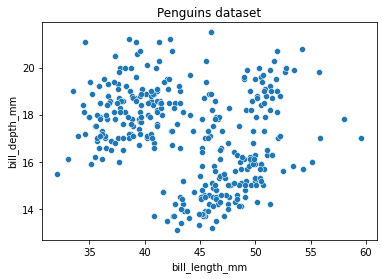

In [6]:
penguins.dropna(inplace=True)
penguins.reset_index(inplace=True)
plt.title('Penguins dataset')
sns.scatterplot(data=penguins, x='bill_length_mm', y='bill_depth_mm')
plt.show()

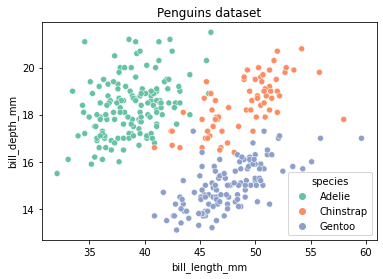

In [7]:
plt.title('Penguins dataset')
sns.scatterplot(data=penguins, x='bill_length_mm', y='bill_depth_mm', hue='species', palette='Set2')
plt.show()

In [8]:
columns = ['bill_length_mm', 'bill_depth_mm']

peng_sample = penguins.filter(columns)
peng_sample.head(3)

,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0


In [9]:
from sklearn.preprocessing import MinMaxScaler
peng_norm = MinMaxScaler().fit_transform(peng_sample)
pd.DataFrame(peng_norm).head()

,0,1
0,0.254545,0.666667
1,0.269091,0.511905
2,0.298182,0.583333
3,0.167273,0.738095
4,0.261818,0.892857


In [10]:
# Now the data has been normalised, we will group it into 3 clusters
from sklearn.cluster import KMeans
peng_kmeans = KMeans(n_clusters=3).fit(peng_norm)

### Evaluation with graphs

In [11]:
# Find the values of the centroids to plot on graph
centroids = pd.DataFrame(peng_kmeans.cluster_centers_)
centroids.columns = columns
centroids

,bill_length_mm,bill_depth_mm
0,0.243784,0.613578
1,0.549303,0.224802
2,0.646378,0.667033


In [12]:
# Make a dataframe of the normalised data to plot on graph
plot_data = pd.DataFrame(peng_norm)
plot_data.columns = columns

# Add a column to say which cluster a penguin belongs to
plot_data['cluster'] = peng_kmeans.labels_

# readd the species as a column so it can be seen on the chart
plot_data = pd.concat([plot_data, penguins.species], axis=1)

plot_data.head()

,bill_length_mm,bill_depth_mm,cluster,species
0,0.254545,0.666667,0,Adelie
1,0.269091,0.511905,0,Adelie
2,0.298182,0.583333,0,Adelie
3,0.167273,0.738095,0,Adelie
4,0.261818,0.892857,0,Adelie


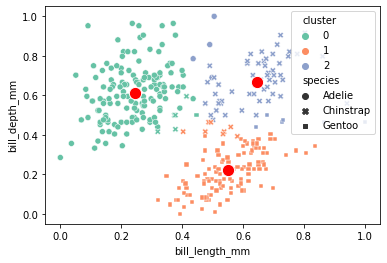

In [13]:
# Time to plot the data, 'hue' determines which categories to colour by, 'palette' determines the colours used
sns.scatterplot(data=plot_data, x='bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set2', style='species')
sns.scatterplot(data=centroids, x='bill_length_mm', y='bill_depth_mm', color='red', s=150)
plt.show()

### Evaluate when checking the distance between centroids

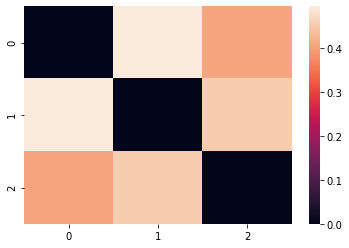

In [14]:
sns.heatmap(get_distances(centroids))
plt.show()

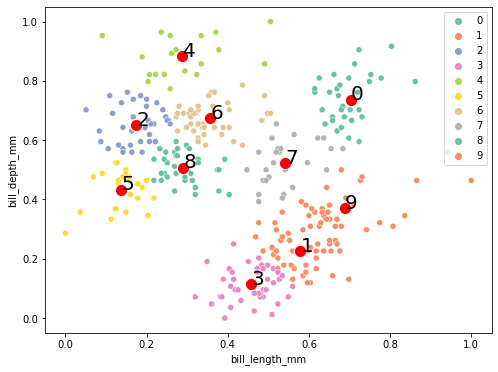

In [15]:
# Now that we've seen how 3 clusters perform, let's see what happens when we use the data to create 10 clusters
temp_kmeans = KMeans(n_clusters=10).fit(peng_norm)

centroids_temp = pd.DataFrame(temp_kmeans.cluster_centers_)
centroids_temp.columns = columns
centroids_temp['cluster_name'] = centroids_temp.index

plot_data['cluster'] = temp_kmeans.labels_

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=plot_data, x='bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set2')
sns.scatterplot(data=centroids_temp, x='bill_length_mm', y='bill_depth_mm', color='red', s=150)
for i in range(centroids_temp.shape[0]):
    plt.text(
        x=centroids_temp['bill_length_mm'][i], 
        y=centroids_temp['bill_depth_mm'][i],
        s=centroids_temp['cluster_name'][i], 
        size=20
    )
plt.show()

dist_temp = get_distances(centroids_temp.drop('cluster_name', axis=1))

#### Using inertia

Inertia is the sum of squared distances of samples to their closest cluster center

Inertia can be recognized as a measure of how internally coherent clusters are

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://scikit-learn.org/stable/modules/clustering.html

In [16]:
peng_kmeans.inertia_

8.769486294749541

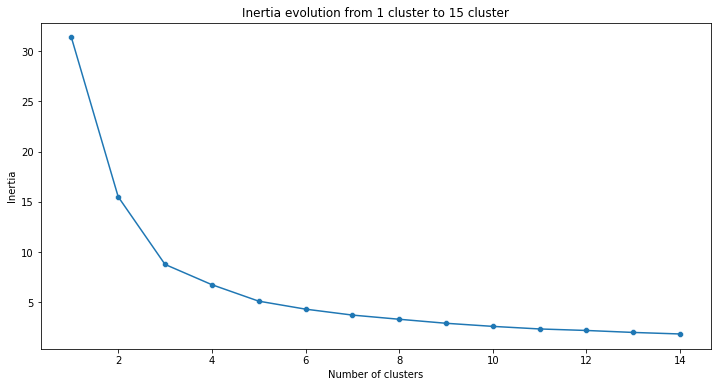

In [17]:
max_k = 15
inertia = []

for k in range(1, max_k): 
    inertia.append(KMeans(n_clusters=k).fit(peng_norm).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia)
sns.scatterplot(x=range(1, max_k), y=inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

##### Food ratings example

In [22]:
food = pd.read_csv('../data/food_ratings - DS003.csv', nrows=12)
food.drop(['age', 'favorite_color'], axis=1, inplace=True)
food.set_index('student', inplace=True)
food

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Akbar,7,0,5,2,3,4,8,8,7
Andreas,7,7,7,2,6,2,3,5,6
Dónal,8,6,8,5,1,5,8,10,10
Hana,5,8,8,8,5,7,9,8,7
Konstantinos,5,7,1,0,7,8,10,2,7
Kristina,9,8,5,0,7,7,9,4,7
Sabrina,6,8,10,0,8,8,10,0,2
Sandrine,10,2,8,0,5,8,10,10,0
Sevgi,6,2,9,0,5,7,10,0,0


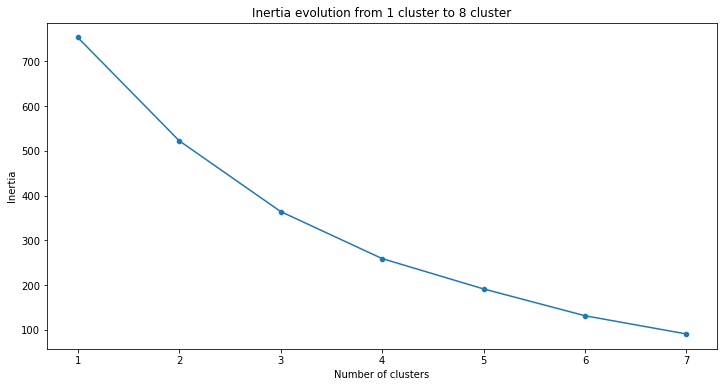

In [23]:
max_k = 8
inertia = []

for k in range(1, max_k): 
    inertia.append(KMeans(n_clusters=k).fit(food).inertia_)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
sns.lineplot(x=range(1, max_k), y=inertia)
sns.scatterplot(x=range(1, max_k), y=inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Silhouette Score

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score(peng_norm, peng_kmeans.labels_)

0.5139272799995429

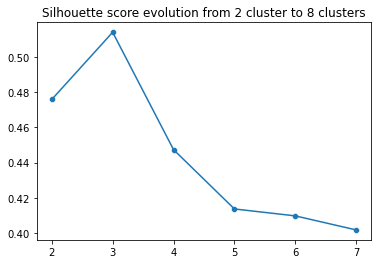

In [15]:
max_k = 8
sil_score = []

for k in range(2, max_k): 
    labels = KMeans(n_clusters=k).fit(peng_norm).labels_
    sil_score.append(silhouette_score(peng_norm, labels))

plt.title(f'Silhouette score evolution from 2 cluster to {max_k} clusters')
sns.lineplot(x=range(2, max_k), y=sil_score)
sns.scatterplot(x=range(2, max_k), y=sil_score)
plt.show()

* For k = 2 the average to silhouette is: 0.4758
	- For cluster = 0 the silhouette value is: 0.6
	- For cluster = 1 the silhouette value is: 0.4


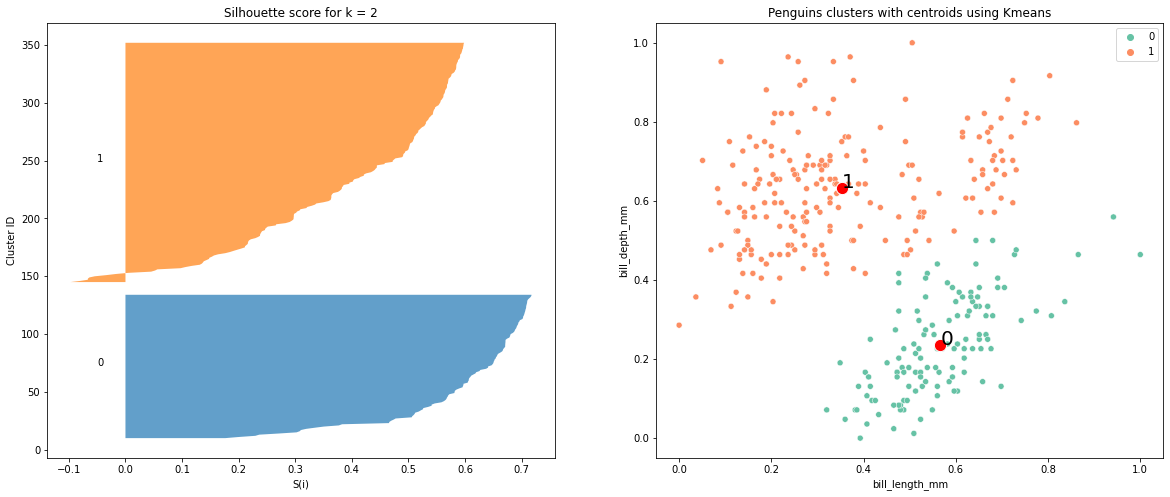

* For k = 3 the average to silhouette is: 0.5139
	- For cluster = 0 the silhouette value is: 0.45
	- For cluster = 1 the silhouette value is: 0.5
	- For cluster = 2 the silhouette value is: 0.57


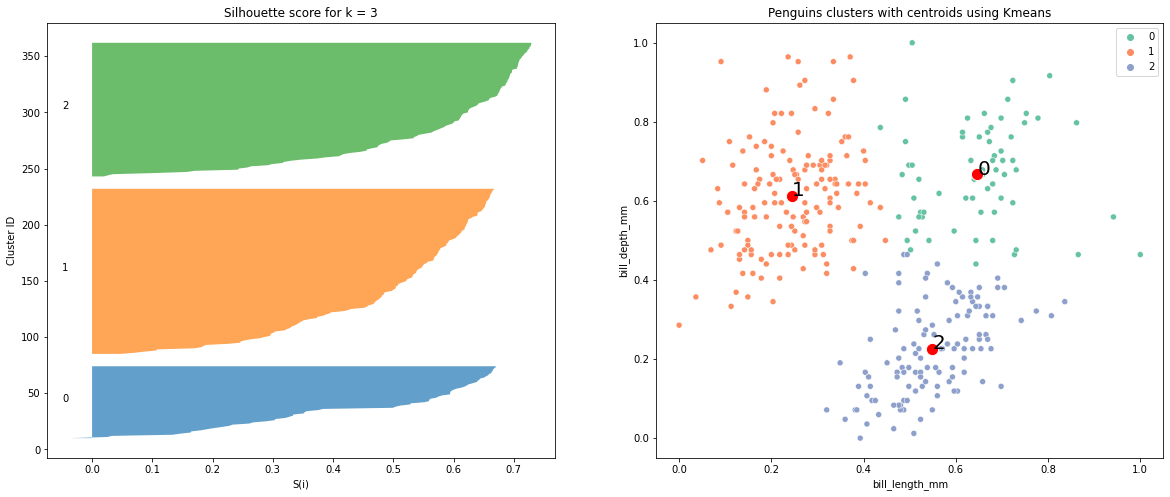

* For k = 4 the average to silhouette is: 0.4474
	- For cluster = 0 the silhouette value is: 0.42
	- For cluster = 1 the silhouette value is: 0.42
	- For cluster = 2 the silhouette value is: 0.55
	- For cluster = 3 the silhouette value is: 0.34


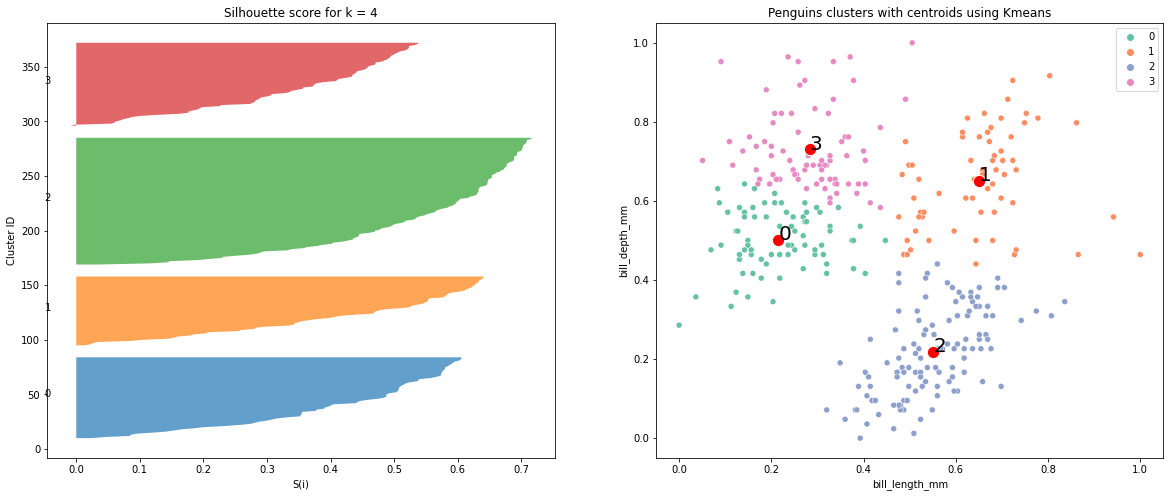

* For k = 5 the average to silhouette is: 0.4131
	- For cluster = 0 the silhouette value is: 0.44
	- For cluster = 1 the silhouette value is: 0.41
	- For cluster = 2 the silhouette value is: 0.33
	- For cluster = 3 the silhouette value is: 0.52
	- For cluster = 4 the silhouette value is: 0.36


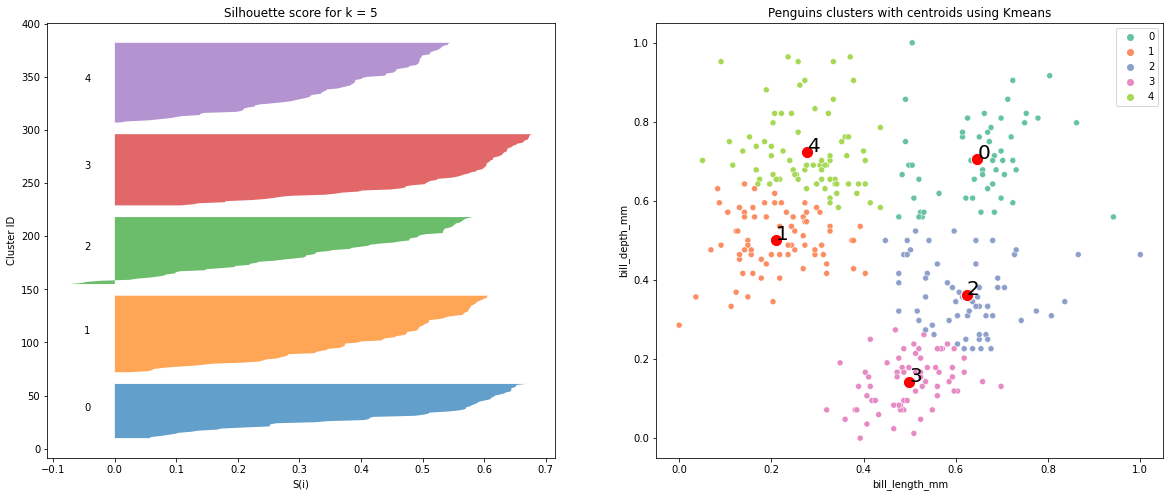

* For k = 6 the average to silhouette is: 0.412
	- For cluster = 0 the silhouette value is: 0.46
	- For cluster = 1 the silhouette value is: 0.42
	- For cluster = 2 the silhouette value is: 0.37
	- For cluster = 3 the silhouette value is: 0.51
	- For cluster = 4 the silhouette value is: 0.36
	- For cluster = 5 the silhouette value is: 0.34


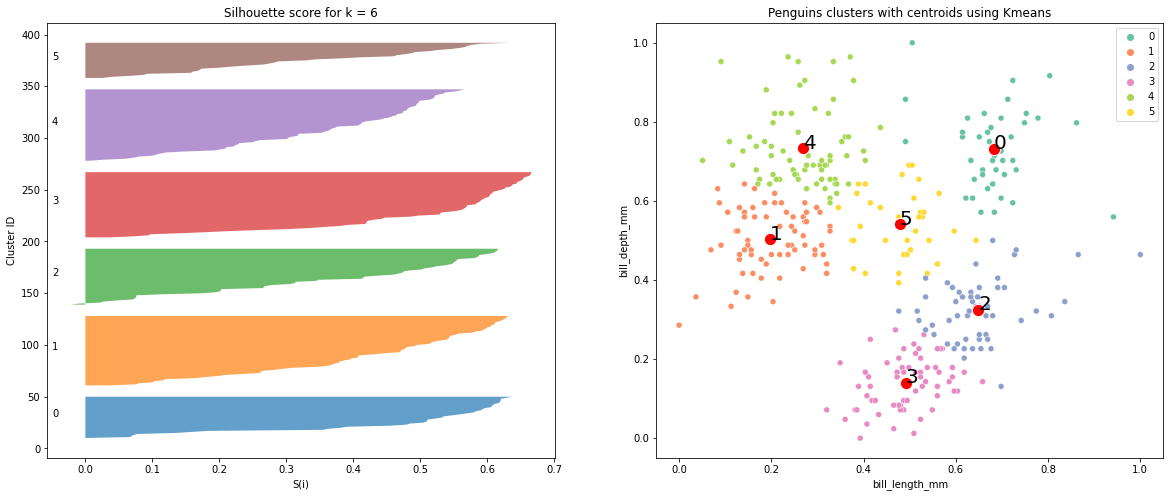

* For k = 7 the average to silhouette is: 0.4033
	- For cluster = 0 the silhouette value is: 0.34
	- For cluster = 1 the silhouette value is: 0.5
	- For cluster = 2 the silhouette value is: 0.32
	- For cluster = 3 the silhouette value is: 0.39
	- For cluster = 4 the silhouette value is: 0.36
	- For cluster = 5 the silhouette value is: 0.35
	- For cluster = 6 the silhouette value is: 0.52


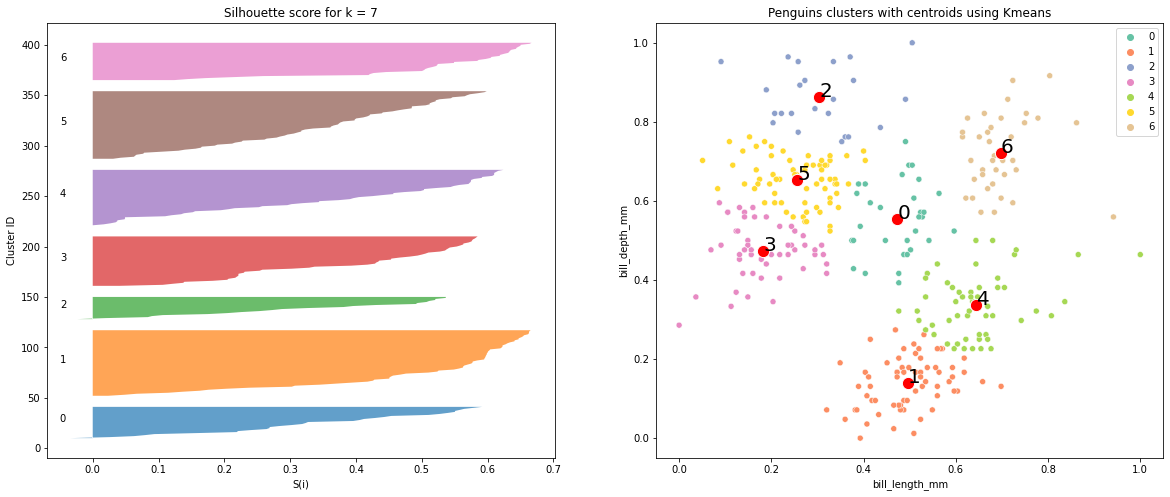

In [16]:
from sklearn.metrics import silhouette_samples
import numpy as np

max_k = 8
data = peng_norm

for k in range(1, max_k): 
    kmean_model = KMeans(n_clusters=k).fit(data)
    labels = kmean_model.labels_
    
    if 1 < k < data.shape[0]: 
        
        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.set_size_inches(20, 8)
        
        sil_avg = silhouette_score(data, labels)
        print(f"* For k = {k} the average to silhouette is: {round(sil_avg,4)}")
        sample_sil_val = silhouette_samples(data, labels)
        
        y_lower = 10
        
        for i in range(k): 
            ith_cluster_sv = sample_sil_val[labels == i]
            print(f"\t- For cluster = {i} the silhouette value is: {round(np.mean(ith_cluster_sv),2)}")
            
            ith_cluster_sv.sort()
            
            # Calculate where to put the silhuette on the y axes
            ith_cluster_size = ith_cluster_sv.shape[0]
            y_upper = y_lower + ith_cluster_size
 
            
            # Paint the cluster
            axis1.fill_betweenx(np.arange(y_lower, y_upper),
                               0, ith_cluster_sv, 
                                alpha = 0.7)
            
            
            # Label the cluster
            axis1.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))
            
            # Calculate the next y lower value for the next cluster of the graph
            y_lower = y_upper + 10 #dejamos vacías 10 posiciones sin muestra
            
        axis1.set_title("Silhouette score for k = %s"%str(k))
        axis1.set_xlabel("S(i)")
        axis1.set_ylabel("Cluster ID")

    if 1 < k: 
        centr_df_temp = pd.DataFrame(kmean_model.cluster_centers_)
        centr_df_temp.columns = columns
        centr_df_temp['cluster_name'] = centr_df_temp.index

        plot_data = pd.DataFrame(data)
        plot_data.columns = columns
        plot_data['cluster'] = kmean_model.predict(data)

        plt.title('Penguins clusters with centroids using Kmeans')
        sns.scatterplot(data=plot_data, x= 'bill_length_mm', y='bill_depth_mm', hue='cluster', palette='Set2')
        sns.scatterplot(data=centr_df_temp, x= 'bill_length_mm', y='bill_depth_mm', color='red', s=150)
        for i in range(centr_df_temp.shape[0]):
            plt.text(
                x=centr_df_temp.bill_length_mm[i], 
                y=centr_df_temp.bill_depth_mm[i],
                s=centr_df_temp.cluster_name[i], 
                size=20
            )
        plt.show()